<a href="https://colab.research.google.com/github/14marcos1/onico/blob/main/onico002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 2025-06-05.png to 2025-06-05 (1).png
Saving 2025-07-04.png to 2025-07-04 (1).png
Saving 2025-08-05.png to 2025-08-05 (1).png
Saving 2025-09-17.png to 2025-09-17 (1).png

4 imagem(ns) carregada(s):
 - 2025-06-05 (1).png
 - 2025-07-04 (1).png
 - 2025-08-05 (1).png
 - 2025-09-17 (1).png
Data da imagem '2025-06-05 (1).png' (ENTER para usar 2025-06-05): 


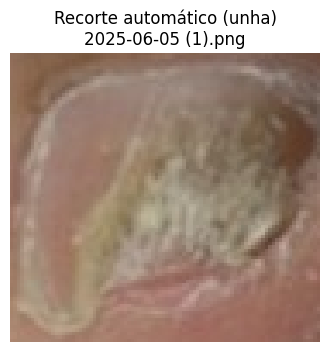

Data da imagem '2025-07-04 (1).png' (ENTER para usar 2025-07-04): 


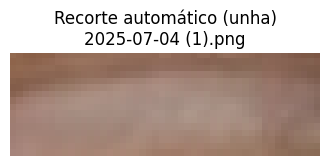

Data da imagem '2025-08-05 (1).png' (ENTER para usar 2025-08-05): 


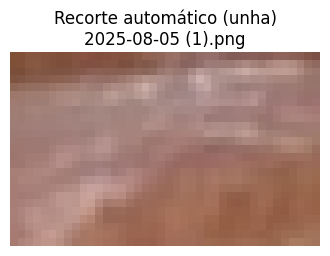

Data da imagem '2025-09-17 (1).png' (ENTER para usar 2025-09-17): 


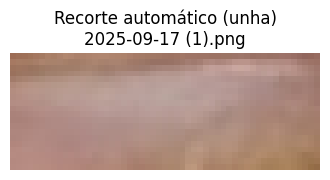


Tabela:


,arquivo,data,indice_amarelo_%
0,2025-06-05 (1).png,2025-06-05,25.793651
1,2025-07-04 (1).png,2025-07-04,0.000000
2,2025-08-05 (1).png,2025-08-05,0.000000
3,2025-09-17 (1).png,2025-09-17,1.792453


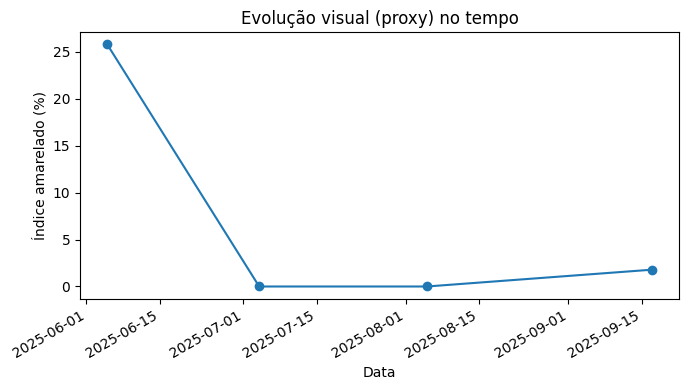

Defina o limiar (%) para 'quase normal' [padrão=10]: 10

Ajuste linear: indice = -0.1929 * dias + 16.25
Estimativa (aprox.) de atingir 10.0%: 2025-07-07 (~32 dias após o início)


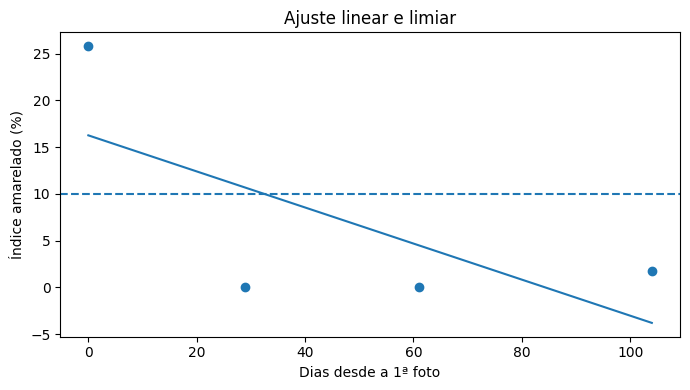

In [ ]:
# ==========================================
# Colab: Acompanhamento visual de onicomicose
# (sem cliques / recorte automático por segmentação)
# ==========================================
# O que faz:
# 1) Upload das imagens
# 2) Lê a data do nome (YYYY-MM-DD) ou pergunta
# 3) Segmenta automaticamente a LÂMINA UNGUEAL (HSV: baixa saturação + alto brilho)
# 4) Recorta a unha (bounding box do maior contorno)
# 5) Calcula "índice amarelado (%)" dentro do recorte (proxy de lesão)
# 6) Plota evolução no tempo e estima quando cruza um limiar (ex.: 10%)

# Se der erro de cv2, descomente:
# !pip -q install opencv-python

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

import cv2  # opencv

# -------- Upload --------
uploaded = files.upload()
paths = [p for p in uploaded.keys() if re.search(r"\.(png|jpg|jpeg|webp)$", p, re.I)]

if len(paths) == 0:
    raise RuntimeError("Nenhuma imagem detectada. Envie .png/.jpg/.jpeg/.webp")

print(f"\n{len(paths)} imagem(ns) carregada(s):")
for p in sorted(paths):
    print(" -", p)

# -------- Utils --------
def pil_to_np_rgb(pil_img: Image.Image) -> np.ndarray:
    return np.array(pil_img.convert("RGB"))

def try_parse_date_from_filename(fname: str):
    m = re.search(r"(20\d{2})[-_](\d{2})[-_](\d{2})", fname)
    if not m:
        return None
    try:
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}", format="%Y-%m-%d")
    except Exception:
        return None

def ask_date(fname: str) -> pd.Timestamp:
    guessed = try_parse_date_from_filename(fname)
    if guessed is not None:
        s = input(f"Data da imagem '{fname}' (ENTER para usar {guessed.date()}): ").strip()
        if s == "":
            return guessed

    while True:
        s = input(f"Data da imagem '{fname}' (YYYY-MM-DD): ").strip()
        try:
            return pd.to_datetime(s, format="%Y-%m-%d")
        except Exception:
            print("Formato inválido. Use YYYY-MM-DD (ex.: 2025-06-05).")

def rgb_to_hsv_np(rgb: np.ndarray) -> np.ndarray:
    """RGB [0..255] -> HSV [0..1] (vetorizado)"""
    rgb = rgb.astype(np.float32) / 255.0
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    cmax = np.max(rgb, axis=-1)
    cmin = np.min(rgb, axis=-1)
    delta = cmax - cmin

    h = np.zeros_like(cmax)
    s = np.zeros_like(cmax)
    v = cmax.copy()

    s[cmax != 0] = delta[cmax != 0] / (cmax[cmax != 0] + 1e-8)

    mask = delta != 0
    rc = (((g - b) / (delta + 1e-8)) % 6)
    gc = (((b - r) / (delta + 1e-8)) + 2)
    bc = (((r - g) / (delta + 1e-8)) + 4)

    rmask = mask & (cmax == r)
    gmask = mask & (cmax == g)
    bmask = mask & (cmax == b)

    h[rmask] = rc[rmask]
    h[gmask] = gc[gmask]
    h[bmask] = bc[bmask]
    h = h / 6.0

    return np.stack([h, s, v], axis=-1)

def yellow_index(hsv01: np.ndarray) -> float:
    """
    Proxy simples: fração de pixels "amarelados" no recorte.
    HSV em escala 0..1.
    """
    h, s, v = hsv01[..., 0], hsv01[..., 1], hsv01[..., 2]
    yellow = (h >= 0.08) & (h <= 0.22) & (s >= 0.18) & (v >= 0.35)
    return float(np.mean(yellow)) * 100.0

def auto_crop_fallback_center(rgb: np.ndarray, x1p=0.25, x2p=0.75, y1p=0.30, y2p=0.80) -> np.ndarray:
    """Fallback: recorte central caso a segmentação falhe."""
    h, w, _ = rgb.shape
    x1 = int(w * x1p); x2 = int(w * x2p)
    y1 = int(h * y1p); y2 = int(h * y2p)
    crop = rgb[y1:y2, x1:x2]
    if crop.size == 0:
        raise RuntimeError("Fallback central gerou recorte vazio.")
    return crop

def auto_crop_nail(rgb: np.ndarray) -> np.ndarray:
    """
    Recorte automático da lâmina ungueal:
    - HSV: baixa saturação (unha/queratina clara) + alto brilho
    - morfologia para limpar
    - maior contorno -> bounding box
    """
    img = rgb.copy()
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Ajustes (você pode refinar se necessário)
    # s < 70 e v > 120 funcionam bem em fotos comuns; aumente v se houver sombra.
    s = hsv[..., 1]
    v = hsv[..., 2]
    mask = ((s < 70) & (v > 120)).astype(np.uint8) * 255

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        # sem contorno -> fallback
        return auto_crop_fallback_center(rgb)

    # maior contorno (heurística)
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)

    # se a área for muito pequena, provavelmente falhou -> fallback
    h_img, w_img, _ = img.shape
    if area < 0.01 * (h_img * w_img):
        return auto_crop_fallback_center(rgb)

    x, y, w, h = cv2.boundingRect(cnt)

    # margem para não cortar bordas da unha
    pad = int(0.06 * max(w, h))
    x1 = max(0, x - pad); y1 = max(0, y - pad)
    x2 = min(w_img, x + w + pad); y2 = min(h_img, y + h + pad)

    crop = img[y1:y2, x1:x2]
    if crop.size == 0:
        return auto_crop_fallback_center(rgb)

    return crop

def downscale_if_needed(rgb: np.ndarray, max_w: int = 600) -> np.ndarray:
    """Acelera processamento sem perder tendência."""
    h, w, _ = rgb.shape
    if w <= max_w:
        return rgb
    scale = max_w / w
    new_w = max_w
    new_h = int(h * scale)
    return np.array(Image.fromarray(rgb).resize((new_w, new_h)))

# -------- Loop principal --------
rows = []

for fname in sorted(paths):
    rgb_full = pil_to_np_rgb(Image.open(fname))
    date = ask_date(fname)

    # (opcional) reduzir a imagem inteira para acelerar segmentação
    rgb_full = downscale_if_needed(rgb_full, max_w=900)

    crop = auto_crop_nail(rgb_full)
    crop = downscale_if_needed(crop, max_w=600)

    # Visualizar recorte
    plt.figure(figsize=(4, 4))
    plt.imshow(crop)
    plt.title(f"Recorte automático (unha)\n{fname}")
    plt.axis("off")
    plt.show()

    hsv01 = rgb_to_hsv_np(crop)
    idx = yellow_index(hsv01)

    rows.append({"arquivo": fname, "data": date, "indice_amarelo_%": idx})

df = pd.DataFrame(rows).sort_values("data").reset_index(drop=True)
print("\nTabela:")
display(df)

# -------- Curva temporal --------
df["dias_desde_inicio"] = (df["data"] - df["data"].min()).dt.days.astype(int)

plt.figure(figsize=(7, 4))
plt.plot(df["data"], df["indice_amarelo_%"], marker="o")
plt.xlabel("Data")
plt.ylabel("Índice amarelado (%)")
plt.title("Evolução visual (proxy) no tempo")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# -------- Estimar quando cruza um limiar --------
x = df["dias_desde_inicio"].to_numpy().astype(float)
y = df["indice_amarelo_%"].to_numpy().astype(float)

if len(df) >= 2:
    a, b = np.polyfit(x, y, 1)

    limiar_str = input("Defina o limiar (%) para 'quase normal' [padrão=10]: ").strip()
    limiar = float(limiar_str) if limiar_str else 10.0

    if abs(a) < 1e-8:
        print("\nInclinação ~0; não dá para estimar queda até o limiar.")
    else:
        x_pred = (limiar - b) / a
        data_pred = df["data"].min() + pd.to_timedelta(int(round(x_pred)), unit="D")

        print(f"\nAjuste linear: indice = {a:.4f} * dias + {b:.2f}")
        print(f"Estimativa (aprox.) de atingir {limiar:.1f}%: {data_pred.date()} (~{int(round(x_pred))} dias após o início)")

        xx = np.linspace(x.min(), max(x.max(), x_pred), 120)
        yy = a * xx + b

        plt.figure(figsize=(7, 4))
        plt.scatter(x, y)
        plt.plot(xx, yy)
        plt.axhline(limiar, linestyle="--")
        plt.xlabel("Dias desde a 1ª foto")
        plt.ylabel("Índice amarelado (%)")
        plt.title("Ajuste linear e limiar")
        plt.tight_layout()
        plt.show()
else:
    print("\nPoucos pontos para estimar tendência.")


Defina o limiar (%) para 'quase normal' [padrão=10]: 10

Cruzamento estimado de 10.0%: 2025-06-23 (~17.8 dias após a 1ª foto)
Intervalo usado: 2025-06-05 (25.79%) -> 2025-07-04 (0.00%)


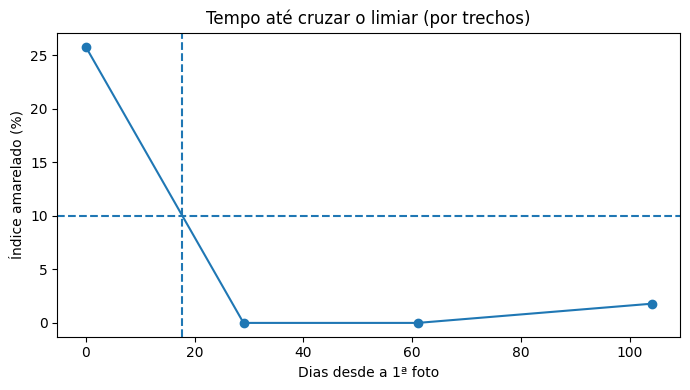

In [ ]:
# -------- Tempo até cruzar o limiar (interpolação por trechos) --------
limiar_str = input("Defina o limiar (%) para 'quase normal' [padrão=10]: ").strip()
limiar = float(limiar_str) if limiar_str else 10.0

df2 = df.sort_values("data").copy()
df2["dias"] = (df2["data"] - df2["data"].min()).dt.days.astype(float)

x = df2["dias"].to_numpy()
y = df2["indice_amarelo_%"].to_numpy()

# encontrar o primeiro cruzamento: y[i-1] > limiar e y[i] <= limiar
cross_idx = None
for i in range(1, len(y)):
    if (y[i-1] > limiar) and (y[i] <= limiar):
        cross_idx = i
        break

if cross_idx is None:
    if np.all(y <= limiar):
        print(f"\nJá estava <= {limiar:.1f}% desde a primeira foto ({df2['data'].min().date()}).")
    else:
        print(f"\nNão cruzou o limiar de {limiar:.1f}% no período observado.")
else:
    i = cross_idx
    x0, x1 = x[i-1], x[i]
    y0, y1 = y[i-1], y[i]

    # interpolação linear no trecho
    # y = y0 + (y1-y0)*(t-x0)/(x1-x0)  -> resolver para y=limiar
    t = x0 + (limiar - y0) * (x1 - x0) / (y1 - y0 + 1e-12)
    data_est = df2["data"].min() + pd.to_timedelta(int(round(t)), unit="D")

    print(f"\nCruzamento estimado de {limiar:.1f}%: {data_est.date()} (~{t:.1f} dias após a 1ª foto)")
    print(f"Intervalo usado: {df2.loc[i-1,'data'].date()} ({y0:.2f}%) -> {df2.loc[i,'data'].date()} ({y1:.2f}%)")

    # plot do trecho
    plt.figure(figsize=(7,4))
    plt.plot(x, y, marker="o")
    plt.axhline(limiar, linestyle="--")
    plt.axvline(t, linestyle="--")
    plt.xlabel("Dias desde a 1ª foto")
    plt.ylabel("Índice amarelado (%)")
    plt.title("Tempo até cruzar o limiar (por trechos)")
    plt.tight_layout()
    plt.show()
